<a href="https://colab.research.google.com/github/MOOwuttichai/NCDs_Listener/blob/main/C_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# เรียกใช้งานเบื้องต้น

In [47]:
# prompt: เชื่อมไดฟ์
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
!pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 73.0 MB/s eta 0:00:00


In [75]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

# ทำการเรียกข้อมูล

## ภาษาไทย

In [49]:
df = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=1)
df1 = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=4)
df_use0 = df[['comments','label']]
df_use1 = df1[['comments','label']]
frames = [df_use0, df_use1]
result = pd.concat(frames)
result = result.reset_index(drop=True)
Data_for_traina_and_test_thai = result

##ภาษาอังกฤษ

In [50]:
df2 = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=0)
df3 = pd.read_excel('/content/drive/MyDrive/เชี่ยงใหม่ (1)/Copy of Data_label_All.xlsx',sheet_name=2)
df_use2 = df2[['comments','label']]
df_use3 = df3[['comments','label']]
frames1 = [df_use2, df_use3]
result1 = pd.concat(frames1)
result1 = result1.reset_index(drop=True)
Data_for_traina_and_test_eng = result1

# ทำความสะอาดข้อมูล

## ภาษาไทย

In [51]:
len_count =[]
for i in range(len(Data_for_traina_and_test_thai)):
  len_count.append(len(Data_for_traina_and_test_thai['comments'][i]))
Data_for_traina_and_test_thai['len_count'] = len_count
Data_model_thai = Data_for_traina_and_test_thai[Data_for_traina_and_test_thai['len_count']>5]
labels = []
for sentiment in Data_model_thai['label']:
  if sentiment == "เล่าประสบการณ์ (tell experience)":
    labels.append(1) #เล่าประสบการณ์ (tell experience)
  elif sentiment == "คำถาม (Question)":
    labels.append(2) #ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
  else:
    labels.append(0)
Data_model_thai['label_num'] = labels

<ipython-input-51-fc8fc31a850c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_model_thai['label_num'] = labels


In [52]:
Data_model_thai

,comments,label,len_count,label_num
30,ว่าพี่,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),6,0
31,Ju Jai,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),6,0
32,Pyn Kt,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),6,0
33,Jahmal,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),6,0
34,Pum Pui,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),7,0
...,...,...,...,...
3132,เคยเป็นตอนช่วงที่ดูแลแม่ในระยะสุดท้ายค่ะ ตื่นเ...,เล่าประสบการณ์ (tell experience),267,1
3133,เคยเป็นตอนนั้นอดนอนสามคืน รู้สึกเลยว่าใจสั่น ...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),267,0
3134,การตรวจ​เลือดเพื่อดูค่าไทรอยด์​ โพแทสเซียม​ ค่...,เล่าประสบการณ์ (tell experience),267,1
3135,ดิฉันเองตอนเข้ารับการผ่าตัดเอาหนองออกจากต่อมน้...,เล่าประสบการณ์ (tell experience),267,1


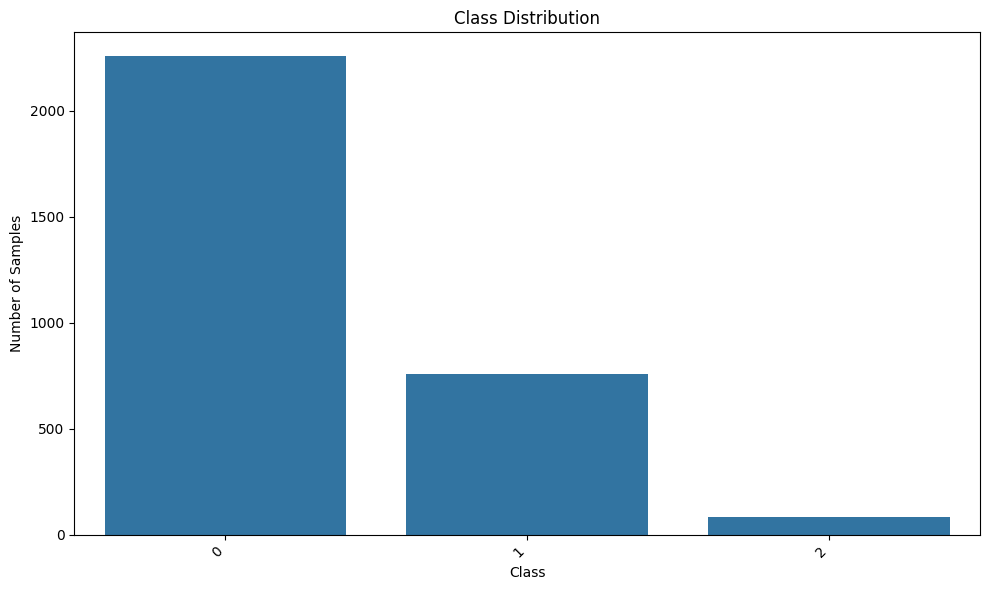

In [53]:
# Count the occurrences of each class in the 'label' column
class_counts =Data_model_thai['label_num'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

เเก้ปัญหาไม่ข้อมูลไม่บาลาน

In [54]:
# Separate features (X) and target (y)
X = Data_model_thai['comments'].values.reshape(-1, 1)  # Reshape for imblearn
y = Data_model_thai['label_num']

# Choose either oversampling or undersampling
# Oversampling:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Undersampling:
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
Data_model_thai_B = pd.DataFrame({'comments': X_resampled.flatten(), 'label': y_resampled})

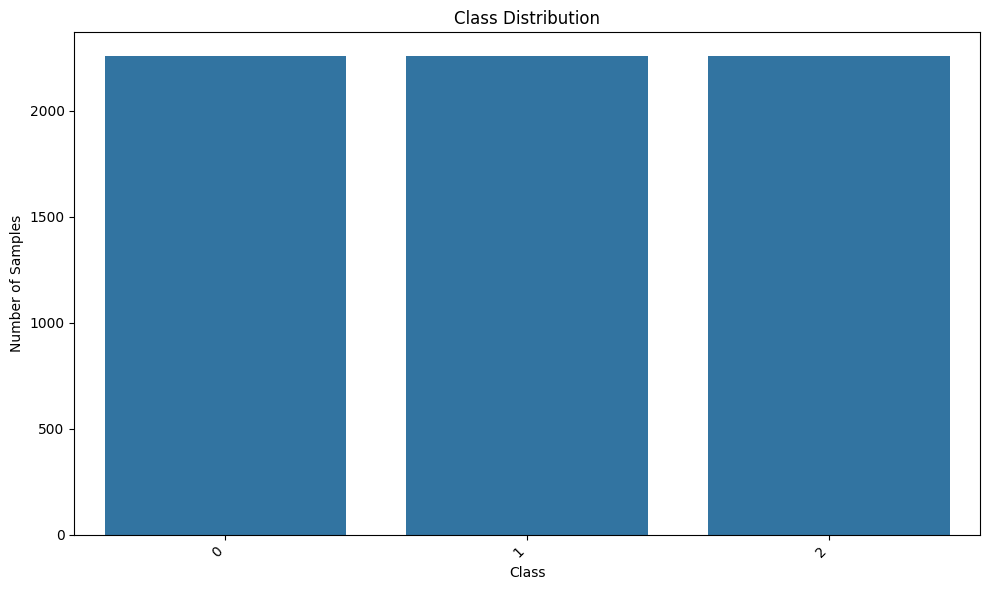

In [55]:
# Count the occurrences of each class in the 'label' column
class_counts =Data_model_thai_B['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

##ภาษาอังกฤษ

In [57]:
len_count =[]
for i in range(len(Data_for_traina_and_test_eng)):
  len_count.append(len(str(Data_for_traina_and_test_eng['comments'][i])))
Data_for_traina_and_test_eng['len_count'] = len_count
Data_model_eng = Data_for_traina_and_test_eng[Data_for_traina_and_test_eng['len_count']>5]
labels = []
for sentiment in Data_model_eng['label']:
  if sentiment == "เล่าประสบการณ์ (tell experience)":
    labels.append(1) #เล่าประสบการณ์ (tell experience)
  elif sentiment == "คำถาม (Question)":
    labels.append(2) #ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant)
  else:
    labels.append(0)
Data_model_eng['label_num'] = labels

<ipython-input-57-0975f7e01ad9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_model_eng['label_num'] = labels


In [58]:
Data_model_eng

,comments,label,len_count,label_num
0,"Hello, I was diagnosed with stage IV anaplasti...",เล่าประสบการณ์ (tell experience),5497,1
1,"I am sorry to hear that you are facing this, a...",เล่าประสบการณ์ (tell experience),4010,1
2,I’m in my last couple weeks of treatment from ...,เล่าประสบการณ์ (tell experience),3956,1
3,Yes. It’s their loss. I’m sorry they are terri...,เล่าประสบการณ์ (tell experience),3914,1
4,"More updates, again for anyone interested who ...",เล่าประสบการณ์ (tell experience),3767,1
...,...,...,...,...
3515,I think not enough people realize how much hor...,เล่าประสบการณ์ (tell experience),4608,1
3516,Our bodies adapted over THOUSANDS of years to ...,ไม่มีประโยชน์/ไม่สำคัญ (useless/unimportant),4848,0
3517,"well, how do people with lung cancer go on smo...",เล่าประสบการณ์ (tell experience),5152,1
3518,It's a very complex issue. I'd always been a l...,เล่าประสบการณ์ (tell experience),5218,1


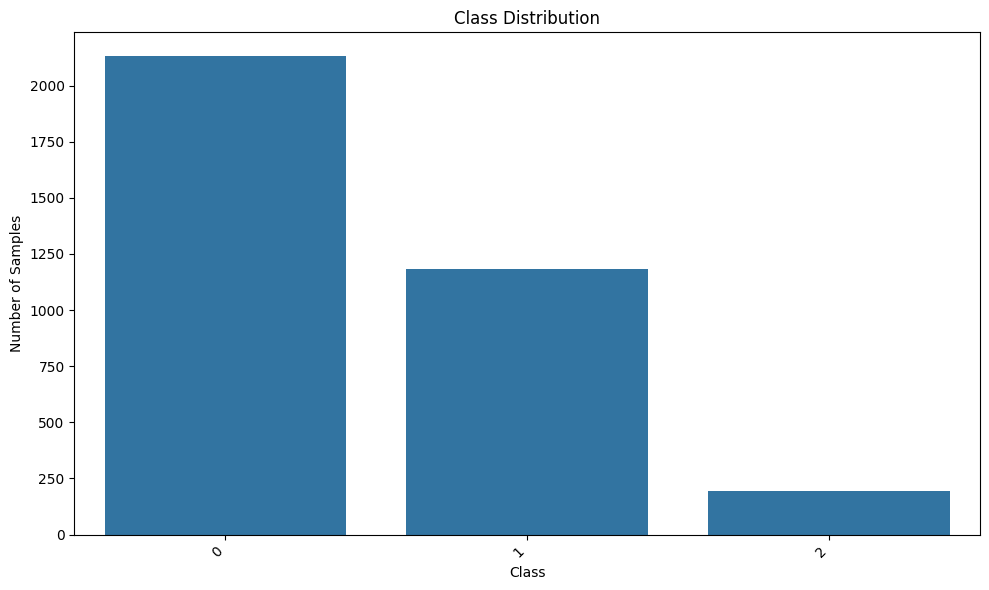

In [59]:
# Count the occurrences of each class in the 'label' column
class_counts =Data_model_eng['label_num'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [60]:
# Separate features (X) and target (y)
X = Data_model_eng['comments'].values.reshape(-1, 1)  # Reshape for imblearn
y = Data_model_eng['label_num']

# Choose either oversampling or undersampling
# Oversampling:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Undersampling:
# undersampler = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
Data_model_eng_B = pd.DataFrame({'comments': X_resampled.flatten(), 'label': y_resampled})

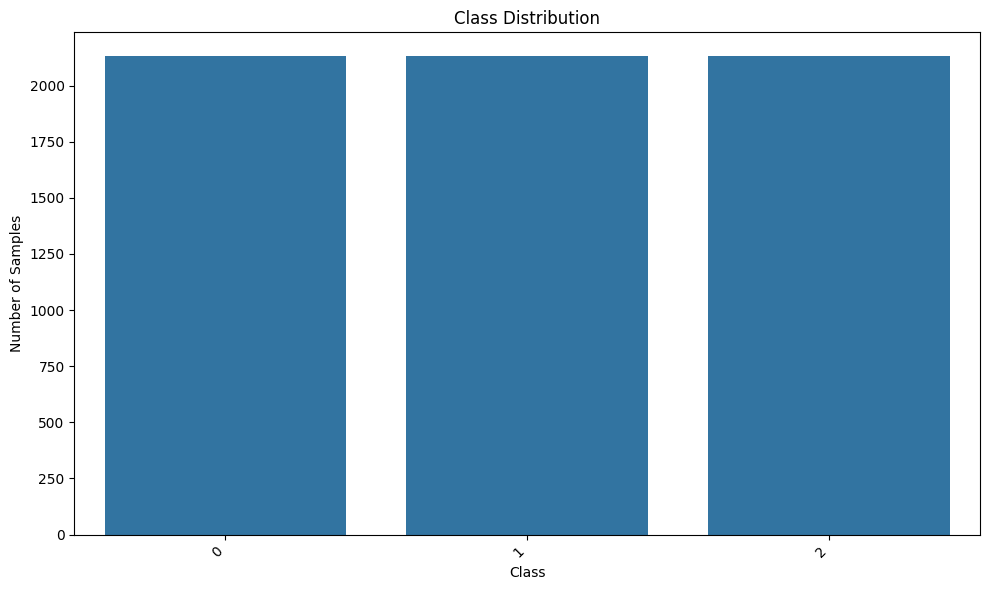

In [61]:
# Count the occurrences of each class in the 'label' column
class_counts =Data_model_eng_B['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [68]:
print(f'จำนวนข้อมูลภาษาอังกฤษ {len(Data_model_eng_B)}')
print(f'จำนวนข้อมูลภาษาไทย {len(Data_model_thai_B)}')

จำนวนข้อมูลภาษาอังกฤษ 6393
จำนวนข้อมูลภาษาไทย 6771


#ฝึกฝนตัวแบบ ทั้งหมด 4 ตัว

##1.support vector machine (SVM)

### ภาษาไทย

###ภาษาอังกฤษ

## 2.logistics regression(LR)

### ภาษาไทย

#### แบ่ง train/test

In [76]:
# Assuming 'Data_model' is your DataFrame
train_df, test_df = train_test_split(Data_model_thai_B, test_size=0.3, random_state=42) # 70/30 split, random_state for reproducibility
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

Training set size: 4739
Testing set size: 2032


In [81]:
def text_process(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ","-"))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split()
                     if word.lower not in thai_stopwords())
    # final = list(final.split(' '))
    return final
train_df['text_tokens'] = train_df['comments'].apply(text_process)
test_df['text_tokens'] = test_df['comments'].apply(text_process)

In [82]:
X_train = train_df[['comments', 'text_tokens']]
y_train = train_df['label']
X_test = test_df[['comments', 'text_tokens'] ] # Changed from X_train to X_test
y_test = test_df['label']  # Changed from y_train to y_test

#### Word Vectorizer และ Bag-of-Words (BoW)

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X_train['text_tokens'])
cvec.vocabulary_

{'สอบถาม': 5403,
 'ค่ะ': 3132,
 'การตรวจเลือด': 2688,
 'ค่า': 3133,
 'เลือด': 6478,
 'สามารถ': 5446,
 'บอ': 4146,
 'กว่า': 2637,
 'เป็นได้': 6322,
 'เลย': 6461,
 'หรอ': 5635,
 'คะ': 3062,
 'เป็น': 6275,
 'เหมือนกัน': 6570,
 'รักษา': 4957,
 'อยู่': 5771,
 'แต่': 6696,
 'หมอ': 5607,
 'ไม่': 7091,
 'เป็นอันตราย': 6312,
 'ถึงแก่ชีวิต': 3740,
 'ตกลง': 3513,
 'คือ': 3100,
 'รัย': 4985,
 'มะเร็ง': 4691,
 'ลำไส้': 5124,
 'ระยะ': 4946,
 'ที่': 3872,
 '3': 156,
 '(': 21,
 'เจอ': 6075,
 'ใน': 6997,
 'ต่อมน้ำเหลือง': 3680,
 '1': 82,
 'ต่อม': 3677,
 'ร่วม': 5051,
 'ด้วย': 3501,
 ')': 41,
 'ตรวจ': 3533,
 'พบ': 4470,
 'เมื่อ': 6395,
 'ตอน': 3557,
 'อายุ': 5849,
 '33': 162,
 'ปกติ': 4214,
 'คน': 2919,
 'ชอบ': 3301,
 'ทาน': 3832,
 'ผัก': 4396,
 'มี': 4733,
 'อาการท้องผูก': 5837,
 'บ่อย': 4203,
 'ตั้งแต่': 3606,
 'ประมาณ': 4248,
 '15': 106,
 'พอ': 4506,
 'ช่วงอายุ': 3360,
 '17': 111,
 'จนถึง': 3181,
 'ช่วง': 3356,
 'เรียน': 6436,
 'มหาวิทยาลัย': 4676,
 'ต้อง': 3707,
 'ยาระบาย': 4839,
 'ช่วย': 3363,
 'เน

#### เริ่มฝึกเเละสร้างโมเดล

In [84]:
train_bow = cvec.transform(X_train['text_tokens'])
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bow, y_train)

LogisticRegression()

In [85]:
from sklearn.metrics import confusion_matrix,classification_report
test_bow = cvec.transform(X_test['text_tokens'])
test_predictions = lr.predict(test_bow)
Model_Evaluation_LOG=classification_report(test_predictions, y_test)

In [86]:
print(Model_Evaluation_LOG)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       664
           1       0.99      0.97      0.98       686
           2       1.00      0.99      0.99       682

    accuracy                           0.98      2032
   macro avg       0.98      0.98      0.98      2032
weighted avg       0.98      0.98      0.98      2032



###ภาษาอังกฤษ

#### แบ่ง train/test

In [87]:
# Assuming 'Data_model' is your DataFrame
train_df, test_df = train_test_split(Data_model_eng_B, test_size=0.3, random_state=42) # 70/30 split, random_state for reproducibility
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

Training set size: 4475
Testing set size: 1918


In [90]:
# prompt: เรียกใช้งาน stopwords ภาษาอังกฤษ

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) # This is your set of stopwords

def text_process(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ","-"))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split()
                     if word.lower() not in stop_words) # Use stop_words here instead of stopwords
    # final = list(final.split(' '))
    return final

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Word Vectorizer และ Bag-of-Words (BoW)

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X_train['text_tokens'])
cvec.vocabulary_

{'Some': 3335,
 'people': 10001,
 'have': 7698,
 'different': 6169,
 'body': 4804,
 'types': 12842,
 'That': 3516,
 'includes': 8132,
 'being': 4640,
 'fat': 6957,
 'The': 3519,
 'only': 9670,
 'time': 12608,
 'I': 2334,
 'was': 13252,
 'in': 8110,
 'a': 3859,
 'somewhat': 11811,
 'socalled': 11773,
 'normalweight': 9519,
 'when': 13351,
 'poor': 10235,
 'enough': 6654,
 'that': 12502,
 'eating': 6498,
 'ramen': 10652,
 'or': 9710,
 'garbage': 7359,
 '(food': 364,
 'out': 9755,
 'of': 9624,
 'the': 12506,
 ')': 573,
 'for': 7182,
 'my': 9343,
 'meals': 8995,
 'Back': 1477,
 'then': 12515,
 '220': 1068,
 '6': 1206,
 "'3": 40,
 'Currently': 1773,
 ',': 601,
 'am': 4164,
 '300': 1120,
 'pounds': 10290,
 'don': 6346,
 "'t": 83,
 'eat': 6493,
 'excessively': 6785,
 'work': 13450,
 'three': 12572,
 'four': 7221,
 'times': 12613,
 'week': 13301,
 'walk': 13225,
 'about': 3876,
 '10,000': 942,
 'steps': 12026,
 '5': 1185,
 'days': 5921,
 'In': 2381,
 'between': 4683,
 'and': 4196,
 'now': 9545

#### เริ่มฝึกเเละสร้างโมเดล

In [94]:
train_bow = cvec.transform(X_train['text_tokens'])
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_bow, y_train)
from sklearn.metrics import confusion_matrix,classification_report
test_bow = cvec.transform(X_test['text_tokens'])
test_predictions = lr.predict(test_bow)
Model_Evaluation_LOG=classification_report(test_predictions, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
print(Model_Evaluation_LOG)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       601
           1       0.86      0.86      0.86       628
           2       1.00      0.95      0.97       689

    accuracy                           0.89      1918
   macro avg       0.89      0.89      0.89      1918
weighted avg       0.90      0.89      0.90      1918



## 3.Bidirectional encoder representations from transformers (BERT)

### ภาษาไทย

In [ ]:
texts = Data_model_thai_B['comments'].tolist()
labels = Data_model_thai_B['label'].tolist()

###ภาษาอังกฤษ

## 4.Long Short-Term Memory (LSTM)

### ภาษาไทย

###ภาษาอังกฤษ